In [ ]:
# Evaluation Notebook File
# file sequence -- after each fold


# The purpose of this notebook is to evaluate model metrics

# Accuracy, F1,

# this notebook should accommodate predictions from ALL Folds: T/V/T

# input:
# test data actual labels
# test data predicted labels
# output:
# Accuracy metric tracker updates


In [ ]:
# mount google drive
from google.colab import drive
# this resets all imported csvs
drive.flush_and_unmount()
# mount/remount
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# library imports

# calculations
import pandas as pd
# file handling
import glob
import os
# regular expressions for file handling
import re
from datetime import datetime
# accuracy metrics:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# plotting:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# share location
shared_drive = r"/content/drive/MyDrive/Capstone_Docs_Shared"

In [ ]:
#### need to bring in data for orignial closing prices for graphing
# load data with close price that isnt shifted backward or scaled

#filename with original combiend data before being labeled
filename = 'kpi_calc_1992_0601_thru_1998_1130.csv'

#combien file name with file path
filepath = os.path.join(shared_drive, filename)

#load csv for later
original_df = pd.read_csv(filepath)


#print(original_df.head())

In [ ]:
# load prediction data

def load_prediction_files(shared_drive):

    #find all csv files that start with predictions_
    filepattern = os.path.join(shared_drive, "predictions_*.csv")
    match_filepaths = glob.glob(filepattern)

    if not match_filepaths:
      print("No prediction files found.")
      return None
    # start dictionary to store most recent files (accounting for new date)
    grouped_files = {}

    # loop over predcition files
    for file_path in match_filepaths:
      #remove csv from file path
      filename = os.path.basename(file_path)
      #remove predictions, csv and parse on _
      parts = filename.replace("predictions_", "").replace(".csv", "").split("_")

        # try to detect timestamp
      timestamp = None
      if len(parts) >= 5 and re.match(r'\d{8}', parts[-2]) and re.match(r'\d{4}', parts[-1]):
          try:
              #parse the datetime string
              timestamp = datetime.strptime(parts[-2] + parts[-1], "%Y%m%d%H%M")
              #remove time stamp form name
              parts = parts[:-2]
          except ValueError:
              pass

      # parse predicted label if it exists, model, fold, features
      # this is to catch for some different named files with the D5_Label
      if parts[0].startswith("D") and "Label" in parts[0]:
          predicted_label = parts[0]
          model = parts[1]
          fold = int(parts[3])
          features = parts[4] if len(parts) > 4 else ''
      else:
          predicted_label = ''
          model = parts[0]
          fold = int(parts[2])
          features = parts[3] if len(parts) > 3 else ''

      # create a tuple that holds the name im looking for
      best = (model, fold, features, predicted_label)

      # check to see if best exists
      exists = grouped_files.get(best)
      # Keep only the most recent file based on time stamp or lack of time stamp
      if exists is None or (timestamp and (exists['timestamp'] is None or timestamp > exists['timestamp'])):
          grouped_files[best] = {
                'model': model,
                'fold': fold,
                'features': features,
                'predicted_label': predicted_label,
                'file_path': file_path,
                'timestamp': timestamp
            }

    # Load only latest files
    loaded_files = []
    for item in grouped_files.values():
        df = pd.read_csv(item['file_path'])

        print(f"Loaded File: {os.path.basename(item['file_path'])} ")

        loaded_files.append({
            'model': item['model'],
            'fold': item['fold'],
            'features': item['features'],
            'predicted_label': item['predicted_label'],
            'df': df,
            'file': os.path.basename(item['file_path'])
        })

    return loaded_files

In [ ]:

# make function to evaluate metrics

### should we be using weighted over macro?

def metrics_eval(df):

  # need to find actual and predicted signals regardless of label (D_5_Label)
  actual_col = [col for col in df.columns if col.startswith("Actual_Signal")]
  predicted_col = [col for col in df.columns if col.startswith("Predicted_Signal")]

  #grab whatever name is present for actual and predicted signals
  actual_sig_col = actual_col[0]
  predicted_sig_col = predicted_col[0]

  # drop NaN rows
  df = df.dropna(subset=[actual_sig_col, predicted_sig_col])

  # get predicted and actual signals from df
  y_true = df[actual_sig_col]
  y_pred = df[predicted_sig_col]

  # calculate metrics

  #accuracy
  accuracy = accuracy_score(y_true, y_pred)

  #precision
  #precision is erroring out, have to add zero_division so that 0
  precision = precision_score(y_true, y_pred, average='macro', zero_division=0 )

  #recall
  recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

  #f1
  f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

  # classification report
  #report = classification_report(y_true, y_pred, zero_division=0)

  return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        #"Report": report,
  }




In [ ]:
#### function to evaluate fold 1 metrics

def fold1_feature_metrics(loaded_files):

  results = []

  # need to loop through list of files to grab filename and df
  #files is dictionary containing filename and corresponding df
  for item in loaded_files:

    #get filename and df
    filename = item['file']
    df = item['df']
    model = item['model']
    fold = item['fold']
    features = item['features']
    predicted_label=item['predicted_label']

    #filter for fold 1
    if fold != 1:
     continue

    #evaluate metrics of each ddf
    metrics = metrics_eval(df)

    #need to convert metric dictionary to df
    #make single row so that dict labels become columns
    metrics_df = pd.DataFrame([metrics])

    # add column model column to df
    metrics_df['Model'] = model

    #add feature column to df
    metrics_df['Feature_Set'] = features

    #add fold column
    metrics_df['Fold'] = fold

    #add label column
    metrics_df['Predicted_Label'] = predicted_label

    #store results
    results.append(metrics_df)

  # combine dfs into one
  df = pd.concat(results, ignore_index=True)

  return df


In [ ]:

# evaluates fold 2 and 3 metrics

def fold_2_3_metrics(loaded_files, target_fold):

  results = []

  # need to loop through list of files to grab filename and df
  #files is dictionary containing filename and corresponding df
  for item in loaded_files:

    #get filename and df
    filename = item['file']
    df = item['df']
    model = item['model']
    fold = item['fold']
    #assign selected features because it does not exist in these folds
    features = 'fe'
    predicted_label=item['predicted_label']

     #filter for for target_fold
    if fold != target_fold:
     continue

    #evaluate metrics of each ddf
    metrics = metrics_eval(df)

    #need to convert metric dictionary to df
    #make single row so that dict labels become columns
    metrics_df = pd.DataFrame([metrics])

    # add column model column to df
    metrics_df['Model'] = model

    metrics_df['Fold'] = fold

    # #add feature column to df
    metrics_df['Feature_Set'] = features

    #add predicted label column
    metrics_df['Predicted_Label'] =predicted_label
    #store results
    results.append(metrics_df)


  # combine dfs into one
  df = pd.concat(results, ignore_index=True)

  return df

In [ ]:
#### function to compare folds
def compare_folds(fold1_df, fold2_df, fold3_df):

  #combine all folds
  all_folds = pd.concat([fold1_df, fold2_df, fold3_df], ignore_index=True)

  #sort
  all_folds = all_folds.sort_values(by=['Model', 'Feature_Set', 'Fold'])

  #change order of columns
  new_column_order = ['Fold', 'Model', 'Feature_Set','Accuracy', 'F1', 'Precision', 'Recall', 'Predicted_Label']

  all_folds = all_folds[new_column_order]

  return all_folds

In [ ]:
# function that accepts fold and model to evaluate metrics by ticker
def metrics_by_ticker(loaded_files, t_model, t_fold):

  results = []

  for item in loaded_files:

    #get filename and df
    df = item['df']
    model = item['model']
    fold = item['fold']
    features = item['features']

    #filter for matching fold and model
    if model != t_model or fold != t_fold:
      continue

    # loop through each ticker in df
    for ticker, group in df.groupby('Ticker'):
      #evaluate each ticker
      metrics = metrics_eval(group)


      metrics.update({
        'Ticker': ticker,
        'Model': model,
        'Fold': fold
    })

      results.append(metrics)

  return pd.DataFrame(results)

In [ ]:
# get specifc model and fold df
def model_fold_df(loaded_files, t_model, t_fold, t_feature_set=None):

  #loop through loaded files
  for item in loaded_files:
    #grab the model and fold i am looking for
    if (item['model'] == t_model and item['fold'] == t_fold and
    #edge case for file 1
    (t_feature_set is None or item['features'] == t_feature_set)):
      #return the desired df
      return item['df']

  return None

In [ ]:
# checking for class imblance to see why one stock is outperforming the others
def class_imbalance(df):

  # check for actual and predicted signals
  # must do this because of the label attached to signal
  actual_sig = [col for col in df.columns if col.startswith('Actual_Signal')][0]
  predicted_sig = [col for col in df.columns if col.startswith('Predicted_Signal')][0]

  for ticker, group in df.groupby('Ticker'):
    print(f'{ticker}:')
    print(group[actual_sig].value_counts(normalize=True))
    print(group[predicted_sig].value_counts(normalize=True))



In [ ]:
# # grab tickers from the prediction files

def get_unique_tickers(loaded_files):


  tickers_in_files = set()

  #loop through files
  for item in loaded_files:
    #grab individual tickers for each file (should all be the same)
    tickers_in_files.update(item['df']['Ticker'].unique())

  return tickers_in_files

In [ ]:
### merge filtered_og_df with uploaded prediction data for specified model
#return df so charts will be easier to graph

def merge_close_price(loaded_files, original_df, model, fold):

  #use grab unique ticker function
  tickers = get_unique_tickers(loaded_files)

  #filter original data for only these tickers
  filtered_og_df = original_df[original_df['Ticker'].isin(tickers)].copy()

  #chagne date to datetime
  filtered_og_df['Date'] = pd.to_datetime(filtered_og_df['Date'])

  #loop through loaded files
  for item in loaded_files:
    #grab the specific one
    if item['model'] == model and item['fold'] == fold:
      df = item['df'].copy()

      # convert dates to datetime for both dfs
      #i am getting an error with this data so using coerce
      df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

      #filtered_og_df['Date'] = pd.to_datetime(filtered_og_df['Date'])

      # merge predicted_df with actual close price that isnt normalized)
      merged_df = pd.merge(df, filtered_og_df[['Date', 'Ticker', 'Close']],
                on=['Date', 'Ticker'], how='left')

      return merged_df


  return None

In [ ]:
#### randomf forest validation set stock MAN
# chosen for accuracy, signal sitribution and f1 score


def plot_stock_signals(merged_df, ticker):

  # need to find actual and predicted signals regardless of label (D_5_Label)
  #actual_col = [col for col in df.columns if col.startswith("Actual_Signal")]
  predicted_col = [col for col in merged_df.columns if col.startswith("Predicted_Signal")]

  #grab whatever name is present for actual and predicted signals
  #actual_sig_col = actual_col[0]
  predicted_sig_col = predicted_col[0]

  #figure size
  plt.figure(figsize=(14, 6))

  # ticker = 'MAN'

  stock_df = merged_df[(merged_df['Ticker'] == ticker) & (merged_df['Close'].notna())].copy()
  #print(MAN_df[['Date', 'Close']].isna().sum())
  #print(MAN_df['Predicted_Signal'].value_counts(dropna=False))

  stock_df = stock_df.sort_values(by='Date')

  #cast predcited values as int so that signals can be read
  stock_df['Predicted_Signal'] = pd.to_numeric(stock_df[predicted_sig_col]).astype(int)



  # line plot for actual closing price
  #plt.scatter(merged_df['Date'], merged_df['Close'], label="MAN Closing Price", color='blue', s=10)
  plt.plot(stock_df['Date'], stock_df['Close'], label=f"{ticker} Closing Price", color='blue', linewidth=2)


  # buy signals for signal 2
  strong_buy = stock_df[stock_df[predicted_sig_col].isin([2])]
  #print(strong_buy)
  plt.scatter(strong_buy['Date'], strong_buy['Close'],
            label='Strong Buy', color='darkgreen', marker='^', s=120)

  # buy signals for signal 1
  buy = stock_df[stock_df[predicted_sig_col].isin([1])]
  plt.scatter(buy['Date'], buy['Close'],
            label='Buy', color='lightgreen', marker='^', s=80)

  #  sell signals for signal -1
  sell = stock_df[stock_df[predicted_sig_col].isin([-1])]
  # print(sell)
  plt.scatter(sell['Date'], sell['Close'],
            label='Sell', color='red', marker='v', s=80)


  # sell signals for both signal -1 and -2
  strong_sell = stock_df[stock_df[predicted_sig_col].isin([-2])]
  #print(strong_sell)
  plt.scatter(strong_sell['Date'], strong_sell['Close'],
            label='Strong Sell', color='darkred', marker='v', s=120)



  plt.xlabel("Date")
  plt.ylabel("Close Price ($)")
  plt.title(f"{ticker} Stock Price with Predicted Buy/Sell Signals")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


##### may need to filter for  smaller time frame but will keep for now

In [ ]:
# function to calcualte cumulative returns and buy and hold returns for actual signals
# need this in order to graph it

def cumulative_returns(merged_df, ticker, buy_signals=[1,2], sell_signals =[-1, -2]):

  #filter for selected ticker
  df = merged_df[(merged_df['Ticker'] == ticker) & (merged_df['Close'].notna())].copy()
  df = df.sort_values('Date')

  # need to find actual and predicted signals regardless of label (D_5_Label)
  actual_col = [col for col in df.columns if col.startswith("Actual_Signal")]
  predicted_col = [col for col in merged_df.columns if col.startswith("Predicted_Signal")]

  #grab whatever name is present for actual and predicted signals
  actual_sig_col = actual_col[0]
  predicted_sig_col = predicted_col[0]

  # cast signal as int
  df[actual_sig_col] = pd.to_numeric(df[actual_sig_col]).astype(int)
  df[predicted_sig_col] = pd.to_numeric(df[predicted_sig_col]).astype(int)

  # calculate daily % return
  df['Daily_Return'] = df['Close'].pct_change()

 # simulate trading based on prediction signals

  # set signal to 1 on buy signals, 0 on sell signals
  #initialize at 0 so that you don't own stock
  df['P_Signal'] = 0

  #if model predicts 'buy' set signal to 1
  #now i own the stock
  df.loc[df[predicted_sig_col].isin(buy_signals), 'P_Signal'] = 1

  # if model predicts sell signal, set to 0
  df.loc[df[predicted_sig_col].isin(sell_signals), 'P_Signal'] = 0

  # need to stay in market until a sell signal is predicted
  # carry current signal forward to remain in or out of market
  df['P_Signal'] = df['P_Signal'].ffill()

  #if holding at 1, earn daily return
  #if holding at 0, no return
  #calculate per day
  df['Predicted_Daily_Gains'] = df['P_Signal'] * df['Daily_Return']

  #calculate cumulative return over time by daily gains
  #each day multiplied by preivous days total
  df['Predicted_Cumulative_Return'] = (1 + df['Predicted_Daily_Gains']).cumprod()



  #simulate trading based on actual signal

    # set signal to 1 on buy signals, 0 on sell signals
  #initialize at 0 so that you don't own stock
  df['A_Signal'] = 0

  #if actual 'buy' set signal to 1
  #now i own the stock
  df.loc[df[actual_sig_col].isin(buy_signals), 'A_Signal'] = 1

  # if actual sell signal, set to 0
  df.loc[df[actual_sig_col].isin(sell_signals), 'A_Signal'] = 0

  # need to stay in market until a sell signal is predicted
  # carry current signal forward to remain in or out of market
  df['A_Signal'] = df['A_Signal'].ffill()

  #if holding at 1, earn daily return
  #if holding at 0, no return
  #calculate per day
  df['Actual_Daily_Gains'] = df['A_Signal'] * df['Daily_Return']

  #calculate cumulative return over time by daily gains
  #each day multiplied by preivous days total
  df['Actual_Cumulative_Return'] = (1 + df['Actual_Daily_Gains']).cumprod()

  #create a buy and hold return
  # start with $1 on day 1 and let it grow/dwindle with daily return
  df['Buy_Hold_Return'] = (1 + df['Daily_Return']).cumprod()

  return df





In [ ]:
# plot stock price with predicted signal against cumulative returns and buy and hold returns

def plot_predicted_signals_with_returns(stock_returns_df, ticker):

  # need to find actual and predicted signals regardless of label (D_5_Label)
  actual_col = [col for col in stock_returns_df.columns if col.startswith("Actual_Signal")]
  predicted_col = [col for col in merged_df.columns if col.startswith("Predicted_Signal")]

  #grab whatever name is present for actual and predicted signals
  actual_sig_col = actual_col[0]
  predicted_sig_col = predicted_col[0]

  # sort df
  stock_returns_df = stock_returns_df.sort_values('Date')

  # set up 2 axes
  fig, ax1 = plt.subplots(figsize=(14, 6))

  # left axis with closing price
  ax1.plot(stock_returns_df['Date'], stock_returns_df['Close'], label="Stock Price", color='blue', linewidth=2)

  #plot predicted signals along historical sotck data
  # buy signals for signal 2
  strong_buy = stock_returns_df[stock_returns_df[predicted_sig_col].isin([2])]
  #print(strong_buy)
  plt.scatter(strong_buy['Date'], strong_buy['Close'],
            label='Strong Buy', color='darkgreen', marker='^', s=100)

  # buy signals for signal 1
  buy = stock_returns_df[stock_returns_df[predicted_sig_col].isin([1])]
  plt.scatter(buy['Date'], buy['Close'],
            label='Buy', color='lightgreen', marker='^', s=100)

  # sell signals for signal -1
  sell = stock_returns_df[stock_returns_df[predicted_sig_col].isin([-1])]
  #print(sell)
  plt.scatter(sell['Date'], sell['Close'],
            label='Sell', color='red', marker='v', s=100)


  # sell signals for both signal -1 and -2
  strong_sell = stock_returns_df[stock_returns_df[predicted_sig_col].isin([-2])]
  #print(strong_sell)
  plt.scatter(strong_sell['Date'], strong_sell['Close'],
            label='Strong Sell', color='darkred', marker='v', s=100)
  #x axis
  ax1.tick_params(axis='x', labelcolor='black', labelsize=16)

  # left axis
  ax1.set_ylabel("Stock Price ($)", color='blue', fontsize=18)
  ax1.tick_params(axis='y', labelcolor='blue', labelsize=16)
  ax1.set_title(f"Stock Price with Predicted Buy/Sell Signals and Cumulative Returns: {ticker}", fontsize = 24)
  ax1.grid(True)

  # right axis with cumulative actual signals returns
  ax2 = ax1.twinx()
  ax2.plot(stock_returns_df['Date'], stock_returns_df['Actual_Cumulative_Return'],
         label="Actual Signal Cumulative Return", color='green', linewidth=2, linestyle='--')

  # right axis with cumulative predicted signals returns
  ax2.plot(stock_returns_df['Date'], stock_returns_df['Predicted_Cumulative_Return'],
         label="Predicted Signal Cumulative Return", color='darkorange', linewidth=2, linestyle='--')

  # right axis with buy and hold strategy
  ax2.plot(stock_returns_df['Date'], stock_returns_df['Buy_Hold_Return'],
         label="Buy & Hold Return", color='black', linewidth=2, linestyle=':')

  # right axis
  ax2.set_ylabel("Cumulative Return", color='darkorange', fontsize=18)
  ax2.tick_params(axis='y', labelcolor='darkorange', labelsize=16)

  # to fix legends posotion, need to add padding
  ymin, ymax = ax1.get_ylim()
  ax1.set_ylim(ymin, ymax * 1.3)

  # legend
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

  plt.tight_layout()
  plt.show()


In [ ]:
#load prediction files from shared drive
loaded_files = load_prediction_files(shared_drive)

# evaluate each folds metrics
metric_fold1_df = fold1_feature_metrics(loaded_files)
metric_fold2_df = fold_2_3_metrics(loaded_files, target_fold=2)
metric_fold3_df = fold_2_3_metrics(loaded_files, target_fold=3)

#combine all folds for comparison of metrics
combined_df = compare_folds(metric_fold1_df, metric_fold2_df, metric_fold3_df)
print(combined_df)

Loaded File: predictions_D5Label_KNN_fold_1_fe.csv 
Loaded File: predictions_D5Label_KNN_fold_1_all.csv 
Loaded File: predictions_D5Label_KNN_fold_2.csv 
Loaded File: predictions_D5Label_KNN_fold_3.csv 
Loaded File: predictions_D5Label_NaiveBayesGauss_fold_1_all.csv 
Loaded File: predictions_D5Label_NaiveBayesGauss_fold_1_fe.csv 
Loaded File: predictions_D5Label_NaiveBayesGauss_fold_2.csv 
Loaded File: predictions_D5Label_NaiveBayesGauss_fold_3.csv 
Loaded File: predictions_D5Label_RandomForestClass_fold_1_fe.csv 
Loaded File: predictions_D5Label_RandomForestClass_fold_1_all.csv 
Loaded File: predictions_D5Label_RandomForestClass_fold_2.csv 
Loaded File: predictions_D5Label_RandomForestClass_fold_3.csv 
Loaded File: predictions_D5Label_MLP_fold_1_fe.csv 
Loaded File: predictions_D5Label_MLP_fold_1_all.csv 
Loaded File: predictions_D5Label_MLP_fold_2.csv 
Loaded File: predictions_D5Label_MLP_fold_3.csv 
    Fold              Model Feature_Set  Accuracy        F1  Precision  \
1      1  

In [ ]:
#compare metrics by ticker for a chosen model and fold
#random forest was chosen to further evaluate because of higher accuracy and and higher F1
#we will evaluate fold 3, the test set
rf_ticker_eval = metrics_by_ticker(loaded_files, 'RandomForestClass', 3)
print(rf_ticker_eval.head())

   Accuracy  Precision    Recall        F1 Ticker              Model  Fold
0  0.618005   0.371860  0.378467  0.374829     AA  RandomForestClass     3
1  0.559611   0.335069  0.331288  0.332105    BRO  RandomForestClass     3
2  0.564477   0.655828  0.414094  0.446543    HOG  RandomForestClass     3
3  0.618005   0.365161  0.350550  0.355850     RF  RandomForestClass     3


In [ ]:
mlp_ticker_eval = metrics_by_ticker(loaded_files, 'MLP', 3)
print(mlp_ticker_eval.head())

   Accuracy  Precision    Recall        F1 Ticker Model  Fold
0  0.632603   0.385424  0.385218  0.383979     AA   MLP     3
1  0.686131   0.419009  0.408212  0.410906    BRO   MLP     3
2  0.566910   0.341545  0.343045  0.339389    HOG   MLP     3
3  0.671533   0.407479  0.367996  0.379007     RF   MLP     3


In [ ]:
#view class imbalance of each stock for specific model and fold
rf_fold3_df = model_fold_df(loaded_files, 'RandomForestClass', 3)
class_imbalance(rf_fold3_df)

AA:
Actual_SignalD_5_Label
 0    0.430657
-1    0.289538
 1    0.250608
 2    0.021898
-2    0.007299
Name: proportion, dtype: float64
Predicted_Signal_D_5_Label
 0    0.457421
-1    0.304136
 1    0.233577
 2    0.004866
Name: proportion, dtype: float64
BRO:
Actual_SignalD_5_Label
 0    0.464720
 1    0.265207
-1    0.240876
 2    0.017032
-2    0.012165
Name: proportion, dtype: float64
Predicted_Signal_D_5_Label
 0    0.530414
 1    0.248175
-1    0.211679
 2    0.004866
-2    0.004866
Name: proportion, dtype: float64
HOG:
Actual_SignalD_5_Label
 0    0.442822
 1    0.267640
-1    0.236010
 2    0.031630
-2    0.021898
Name: proportion, dtype: float64
Predicted_Signal_D_5_Label
 0    0.486618
-1    0.260341
 1    0.238443
 2    0.012165
-2    0.002433
Name: proportion, dtype: float64
RF:
Actual_SignalD_5_Label
 0    0.527981
 1    0.245742
-1    0.209246
 2    0.009732
-2    0.007299
Name: proportion, dtype: float64
Predicted_Signal_D_5_Label
 0    0.608273
 1    0.206813
-1    0.182

In [ ]:
# merge together predicted df of choosing and original stock data (closing price) unscaled
merged_df = merge_close_price(loaded_files, original_df, 'RandomForestClass', 3)
#print(merged_df.head())

#print unique tickers in merged_df to see ticker options
tickers = merged_df['Ticker'].unique()
print(tickers)

['AA' 'RF' 'BRO' 'HOG']


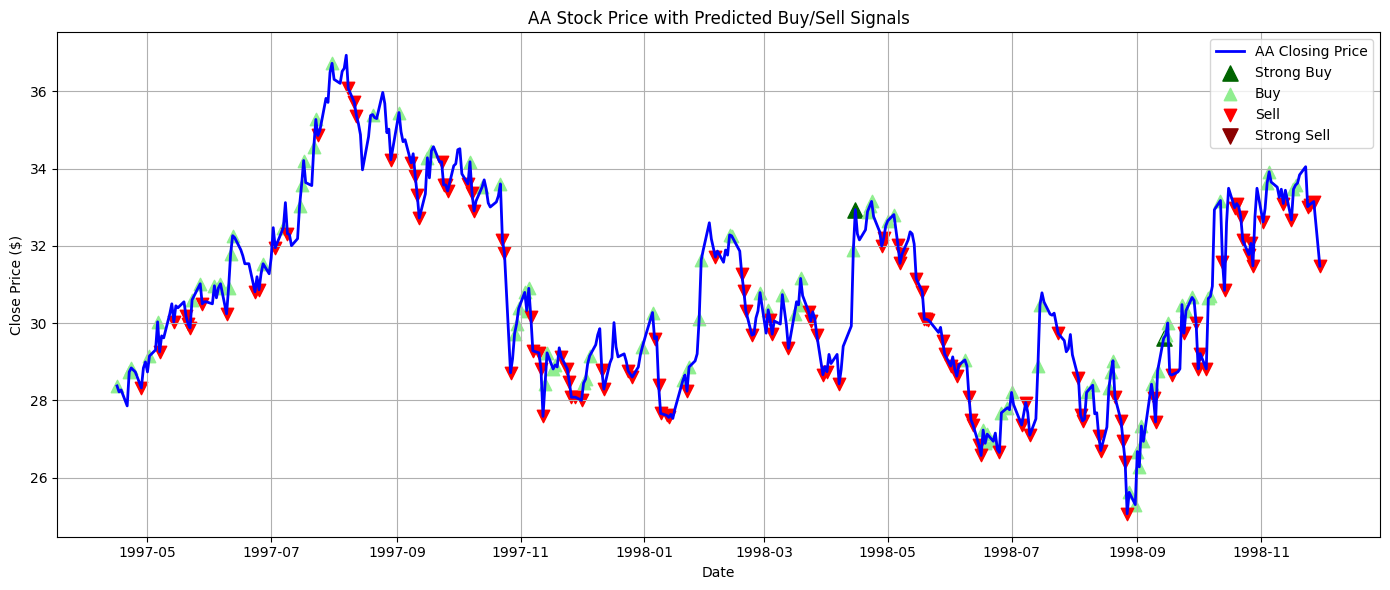

In [ ]:
#after merging data, plot historical stock of stocks in df with predicted signals
plot_stock_signals(merged_df, 'AA')

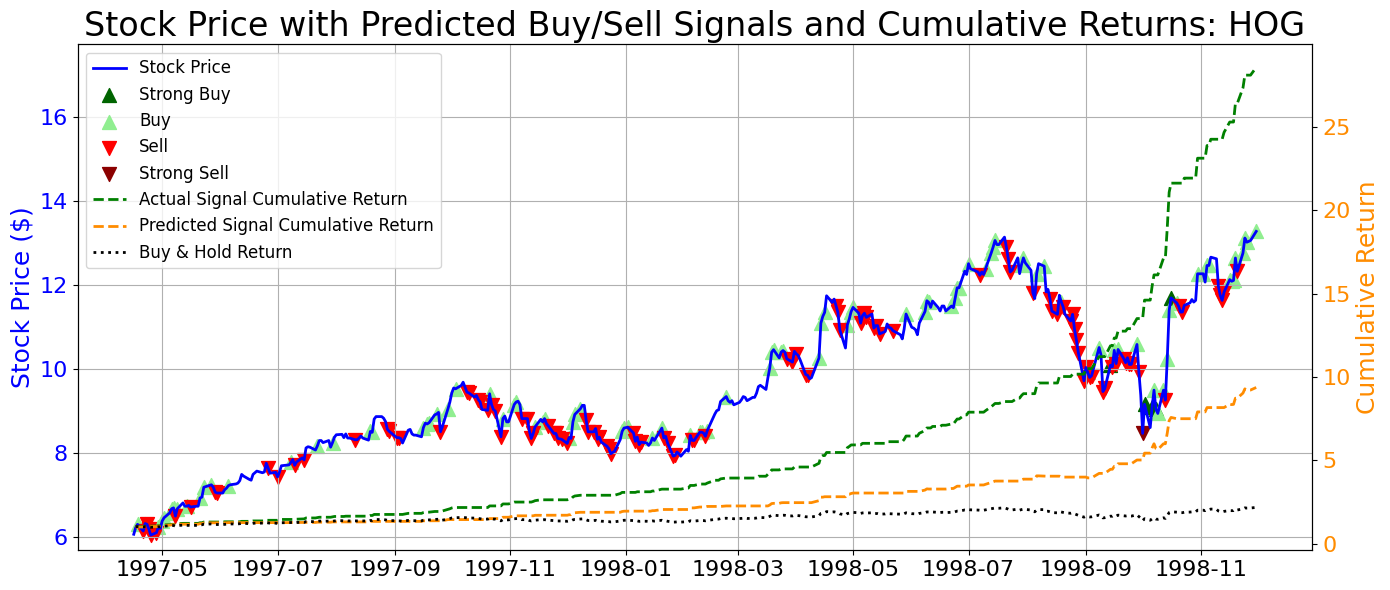

In [ ]:
#calculate cumulative returns
stock_df = cumulative_returns(merged_df, ticker='HOG')

#plot cumulative return for predicted and actual signals
# and basic buy hold returns with historical stock data with predicted signals
plot_predicted_signals_with_returns(stock_df, 'HOG')

['AA' 'RF' 'BRO' 'HOG']


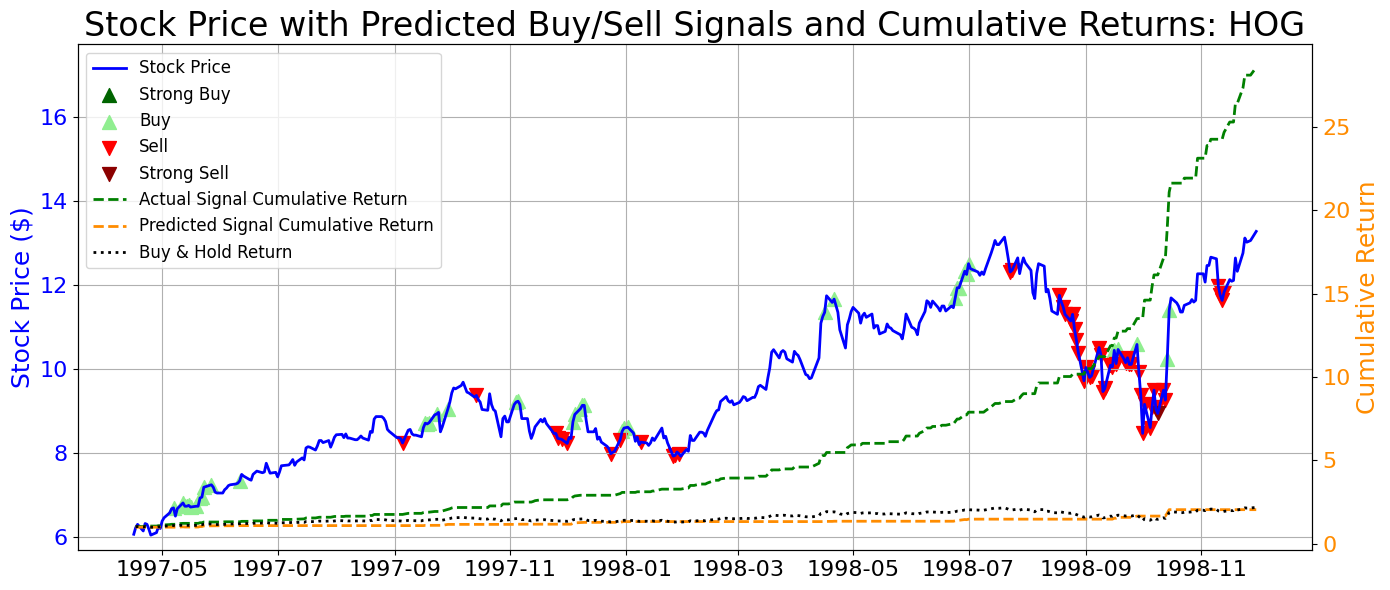

In [ ]:
# all stocks were evaluated for each model
#all models out perform the basic by and hold strategy except for the KNN model

#looking at KNN
# merge together predicted df of choosing and original stock data (closing price) unscaled
KNN_merged_df = merge_close_price(loaded_files, original_df, 'KNN', 3)
#print(merged_df.head())

#print unique tickers in merged_df to see ticker options
tickers = KNN_merged_df['Ticker'].unique()
print(tickers)

#calculate cumulative returns
KNN_stock_df = cumulative_returns(KNN_merged_df, ticker='HOG')

#plot cumulative return for predicted and actual signals
# and basic buy hold returns with historical stock data with predicted signals
plot_predicted_signals_with_returns(KNN_stock_df, 'HOG')
